In [1]:
# Load relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import warnings
from sklearn.cluster import KMeans 

In [2]:
## load data set
carmax_df = pd.read_csv('CaseDataRemodeled.csv')
top10_df = pd.read_csv('Top10ByIncome.csv')

## Time to Cluster - Gonna use k-means initially 




In general, we can cluster observations on the basis of the features in order to identify subgroups among the observations, or we can cluster fea- tures on the basis of the observations in order to discover subgroups among the features. In what follows, for simplicity we will discuss clustering obser- vations on the basis of the features, though the converse can be performed by simply transposing the data matrix.

In [3]:
top10_df.columns
top10_df = top10_df.drop('Unnamed: 0', axis=1)

In [4]:
top10_df['purchase_model']

0               CAMRY
1              ALTIMA
2             COROLLA
3              MALIBU
4              ACCORD
5               CIVIC
6               VERSA
7               FOCUS
8              IMPALA
9              ESCAPE
10               F150
11              CAMRY
12             ALTIMA
13             ACCORD
14               C300
15                G37
16                328
17               EDGE
18           RAM 1500
19            MUSTANG
20               F150
21              CAMRY
22                328
23               C300
24             ACCORD
25             ALTIMA
26                G37
27           RAM 1500
28               E350
29              PRIUS
            ...      
90             ALTIMA
91              CAMRY
92             ACCORD
93               F150
94           RAM 1500
95             MALIBU
96             SONATA
97            MUSTANG
98               C300
99     SILVERADO 1500
100            ALTIMA
101              F150
102             CAMRY
103            ACCORD
104       

In [5]:
cluster_df = carmax_df[carmax_df['purchase_model'].isin(list(set(top10_df['purchase_model'])))]
cluster_df = cluster_df.drop('insert_num', axis=1)

In [6]:
cluster_df

,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_age,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,post_purchase_satisfaction,vehicle_warranty_used,subsequent_purchases,AgeBin
1,FORD,F150,2007,15001.0,20000.0,0,0,51 - 60,0 - 20000,F,1,19.0,?,0,0,Fifties
2,BMW,328,2010,25001.0,30000.0,1,1,41 - 50,60001 - 80000,F,1,21.0,?,0,0,Forties
5,NISSAN,ALTIMA,2009,15001.0,20000.0,1,1,21 - 30,60001 - 80000,U,0,2.0,?,1,1,Twenties
8,FORD,ESCAPE,2010,15001.0,20000.0,1,1,41 - 50,40001 - 60000,U,1,14.0,?,1,0,Forties
10,NISSAN,SENTRA,2009,10001.0,15000.0,0,1,61 - 70,20001 - 40000,U,0,NaN,?,0,1,Sixties
11,NISSAN,VERSA,2011,10001.0,15000.0,0,0,0 - 20,?,F,0,58.0,?,0,1,UnderTwenty
17,FORD,F150,2006,15001.0,20000.0,0,1,21 - 30,40001 - 60000,U,0,22.0,?,1,0,Twenties
18,TOYOTA,COROLLA,2009,15001.0,20000.0,1,1,31 - 40,60001 - 80000,F,1,24.0,?,0,0,Thirties
19,FORD,FOCUS,2012,10001.0,15000.0,1,1,31 - 40,80001 - 100000,M,1,7.0,?,0,0,Thirties
24,TOYOTA,TUNDRA,2009,20001.0,25000.0,1,1,31 - 40,60001 - 80000,M,0,11.0,?,0,6,Thirties


In [7]:
len(list(set(top10_df['purchase_model'])))

30

In [8]:
cluster_df.dtypes

purchase_make                   object
purchase_model                  object
purchase_vehicle_year            int64
purchase_price_LB              float64
purchase_price_UB              float64
trade_in                         int64
vehicle_financing                int64
customer_age                    object
customer_income                 object
customer_gender                 object
customer_previous_purchase       int64
customer_distance_to_dealer    float64
post_purchase_satisfaction      object
vehicle_warranty_used            int64
subsequent_purchases             int64
AgeBin                          object
dtype: object

In [9]:
cluster_df = cluster_df.drop('customer_age', axis=1)
cluster_df = cluster_df.drop('post_purchase_satisfaction', axis=1)

In [10]:
# function to transform into numerical bins by normal/gaussian distribution
def categorical_transform(col):
    classnames, factorval, rank = np.unique(col, return_inverse = True,return_counts = True)
    
    temp = np.array(rank)
    temp.sort()
    temp = np.concatenate((temp[::2], temp[~np.isin(temp,temp[::2])][::-1]))

    category_count = {}
    for i in range(len(classnames)):
        category_count[classnames[i]] = rank[i]
    
    vals = [i * 5 for i in range(len(temp))]
    
    for i in range(len(temp)):
        for key, value in category_count.items():
            if value == temp[i]:
                category_count[key] = vals[i]
            
    check_list = list(col)
    for i in range(len(check_list)):
        for key, value in category_count.items():
            if check_list[i] == key:
                factorval[i] = value 
                break
    
    return category_count, factorval

In [11]:
## references of transformation for later 
references = {}

for i in cluster_df.columns:
    if cluster_df[i].dtype == 'object':
        classes = cluster_df[i]
        references[i], cluster_df[i] = categorical_transform(classes)

In [12]:
cluster_df.dtypes

purchase_make                    int64
purchase_model                   int64
purchase_vehicle_year            int64
purchase_price_LB              float64
purchase_price_UB              float64
trade_in                         int64
vehicle_financing                int64
customer_income                  int64
customer_gender                  int64
customer_previous_purchase       int64
customer_distance_to_dealer    float64
vehicle_warranty_used            int64
subsequent_purchases             int64
AgeBin                           int64
dtype: object

In [13]:
cluster_df

,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,AgeBin
1,20,90,2007,15001.0,20000.0,0,0,40,10,1,19.0,0,0,35
2,50,25,2010,25001.0,30000.0,1,1,20,10,1,21.0,0,0,20
5,30,75,2009,15001.0,20000.0,1,1,20,0,0,2.0,1,1,25
8,20,50,2010,15001.0,20000.0,1,1,25,0,1,14.0,1,0,20
10,30,45,2009,10001.0,15000.0,0,1,30,0,0,NaN,0,1,15
11,30,40,2011,10001.0,15000.0,0,0,35,10,0,58.0,0,1,10
17,20,90,2006,15001.0,20000.0,0,1,25,0,0,22.0,1,0,25
18,25,85,2009,15001.0,20000.0,1,1,20,10,1,24.0,0,0,30
19,20,100,2012,10001.0,15000.0,1,1,15,5,1,7.0,0,0,30
24,25,140,2009,20001.0,25000.0,1,1,20,5,0,11.0,0,6,30


In [14]:
from sklearn.preprocessing import StandardScaler

X = cluster_df.values[:,:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[-0.52362348,  0.46550396, -1.30434939, ..., -0.5351671 ,
        -0.44335392,  1.27463107],
       [ 2.24695256, -1.39124196,  0.0304836 , ..., -0.5351671 ,
        -0.44335392, -0.86425427],
       [ 0.39990186,  0.03702413, -0.41446073, ...,  1.86857526,
         0.39398434, -0.15129249],
       ...,
       [ 0.86166454,  0.17985074, -1.30434939, ..., -0.5351671 ,
        -0.44335392, -0.15129249],
       [-0.06186081, -1.10558875,  0.47542793, ..., -0.5351671 ,
        -0.44335392,  1.27463107],
       [-0.98538616, -0.24862909,  0.92037227, ..., -0.5351671 ,
        -0.44335392,  0.56166929]])

Lets run model cluster

In [15]:
num_clusters = 5

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=50,algorithm = "elkan")
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[1 1 0 ... 2 1 2]


In [16]:
cluster_df["Labels"] = labels
cluster_df.head(5)

,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,AgeBin,Labels
1,20,90,2007,15001.0,20000.0,0,0,40,10,1,19.0,0,0,35,1
2,50,25,2010,25001.0,30000.0,1,1,20,10,1,21.0,0,0,20,1
5,30,75,2009,15001.0,20000.0,1,1,20,0,0,2.0,1,1,25,0
8,20,50,2010,15001.0,20000.0,1,1,25,0,1,14.0,1,0,20,1
10,30,45,2009,10001.0,15000.0,0,1,30,0,0,NaN,0,1,15,2


In [17]:
# can easily change agg argument ---- is mode best?
#cluster_df.groupby('Labels').agg(lambda x: pd.Series.mode(x)[0])
cluster_df.groupby('Labels').mean()

,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,AgeBin
Labels,,,,,,,,,,,,,,
0,26.559683,72.624875,2009.063102,13424.550930,18423.550930,0.408396,0.826983,28.623002,6.520054,0.014197,12.228338,0.999956,0.533031,25.983103
1,26.709168,72.113485,2010.001780,14994.769470,19993.769470,0.581264,0.791589,27.391411,6.460614,1.000000,12.674942,0.217891,0.573075,26.358033
2,27.608663,72.714492,2009.809269,13020.599654,18019.599654,0.359044,0.805137,28.922019,6.562379,0.000000,13.903857,0.000000,0.510605,25.946869
3,23.505155,67.216495,2010.103093,16289.659794,21288.659794,0.546392,0.804124,27.164948,6.443299,0.164948,2103.257732,0.216495,0.556701,26.546392
4,18.786881,78.759121,2010.983939,24776.737627,29775.737627,0.591609,0.717878,27.140704,6.137373,0.164102,14.218193,0.110961,0.537476,26.168901


#### Questions To Ask:
    How many clusters do we actually want?
    
    Are certain columns influencing negatively or contradicting? 
        e.g. cluster one average make is a Ford with Nissan Altima average model
    

In [18]:
references['purchase_make']

{'BMW': 50,
 'CHEVROLET': 15,
 'DODGE': 40,
 'FORD': 20,
 'HONDA': 35,
 'HYUNDAI': 45,
 'INFINITI': 0,
 'JEEP': 5,
 'MERCEDES-BENZ': 10,
 'NISSAN': 30,
 'TOYOTA': 25}

In [19]:
references['purchase_model']

{'328': 25,
 'ACCORD': 80,
 'ALTIMA': 75,
 'AVENGER': 125,
 'C300': 20,
 'CAMRY': 70,
 'CIVIC': 60,
 'COROLLA': 85,
 'CR-V': 130,
 'E350': 145,
 'EDGE': 120,
 'ESCAPE': 50,
 'F150': 90,
 'FOCUS': 100,
 'G37': 135,
 'GRAND CHEROKEE': 5,
 'IMPALA': 55,
 'MALIBU': 65,
 'MUSTANG': 105,
 'PRIUS': 15,
 'RAM 1500': 30,
 'RAV4': 35,
 'ROGUE': 110,
 'SENTRA': 45,
 'SILVERADO 1500': 115,
 'SONATA': 95,
 'TUNDRA': 140,
 'VERSA': 40,
 'WRANGLER': 10,
 'X5': 0}

### HCluster

In [20]:
#from sklearn.cluster import FeatureAgglomeration 
#import time as time
#hcluster = FeatureAgglomeration(n_clusters= None, linkage ='ward',distance_threshold = 0).fit(data_scaled)

https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02


https://gist.github.com/PulkitS01/8ac9bf3b54eb59b4e1d4eaa21d3d774e#file-scaling_data-py

In [21]:
from sklearn.preprocessing import normalize
#Normalizer().fit_transform(X))

try:
    cluster_df = cluster_df.drop('Labels', axis=1)
    X = cluster_df.values[:,:]
except:
    X = cluster_df.values[:,:]


X = np.nan_to_num(X)

data_scaled = normalize(X)
data_scaled = pd.DataFrame(data_scaled,columns = cluster_df.columns)


#cluster_dataset = StandardScaler().fit_transform(X)
#cluster_dataset


In [22]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [23]:
from sklearn.cluster import AgglomerativeClustering
hclustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(data_scaled.sample(frac = 0.2))

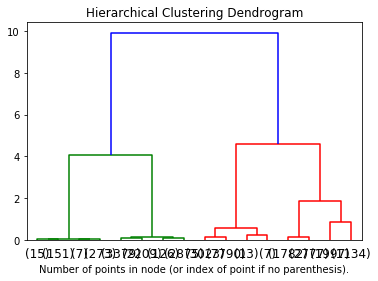

In [24]:
from scipy.cluster.hierarchy import dendrogram

plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(hclustering, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()